# Draft notes on statistical analysis and inference. 

In these notes, I intended to summarize and clarify some concepts and statistical techniques. Multidisciplinary work poses the challenge of handling different definitions and naming conventions. The motivation for creating this document is that we will use a mixture of methods, some of them ubiquitous in machine learning, while some are standard on behavioral sciences. Different scientific communities have different standards and naming conventions. I have noticed, though, that most of the underlying ideas are similar, and very often, the same procedure is used but with a small implementation or nomenclature difference. I will try to clarify those things in this document, homogenize name conventions, and summarize the main tools and their underlying hypothesis. 

## Index 
### Section 1: Introduction to naive bayes
- 1.1: Two classes canonical problem
- 1.2: Priors
- 1.3: Classification and confidence measures 

### Section 2: Estimation of PDFs and parameters
- 2.1: Empirical Distribution Function
- 2.2: The Bootstrap
- 2.3: Parametric Inference, Maximum Likelihood

### Section 3: Hypothesis testing (Missing)
- 3.1: Definition and general concepts
- 3.2: Limitations and some comments
- 3.3: Examples

### Section 4: Others (Missing)
- Effect size
- chi-square (correlation between categories/ groups)
- ANOVA 
- General linear model (GLM) / logistic regression (binary output or prediction)
- t-test
- ICC  (test reliability for continous variables).
- kappa  (Same as ICC but for binary variables). 

## Refs
1. Larry Wasserman, "All of Statistics, A Concise Course in Statistical Inference"
2. Peter Bruce And Andrew Bruce, "Practical Statistics for Data Scientists"
3. Andy Field, "Discovering Statistics using SPSS"
4. Alexander Gordon et al., "Control of the Mean Number of False Discoveries, Bonferroni and Stability of Multiple Testing". 
5. Jacob Cohen, "Things I have Learned (So Far)"
6. Thomas Cover and Joy Thomas, "Elements of Information Theory"
7. Richard Duda et al., "Pattern Classification"
8. Judea Pearl et al., "Causal Inference in Statistics"
9. Steven Kay, "Fundamentals of Statistical Signal Processing, Volume I: Estimation Theory"

----
Contributors: _Finish this once we have a complete list and this is done_.

matias.di.martin.uy@gmail.com.                                     Durham, 2020

## Section 1: Introduction to naive bayes
- 1.1: Two classes canonical problem
- 1.2: Priors
- 1.3: Classification and confidence measures

Summary: In this section, I want to illustrate some basic ideas of "classification." It will help us to understand some of the notation and some of the general concepts used throughout this document. It will illustrate the role of priors, the problem of classification in the context of imbalanced classes, and how to estimate classification performance correctly. Finally, it will also describe and provide some of the most important tools we will use for the data and statistical analysis. 

### Example: ASD or Non-ASD?
Let us start with a realistic example. We want to classify if a certain subject "$i$" has ASD or not, and we want to do it, by measuring only one number (a.k.a. feature) "x." Notation: the universe of subjects will be noted as $\mathcal{U}$, for a subject $s_i\in\mathcal{U}$, $y_i\stackrel{def}{=}1$ if the subject has ASD (and $0$ otherwise). And we measure a certain quantity $x$, for example, the delay on head-turning after a name call. So, given a subject $s_i$, we are provided with a value of $x_i$ (delay in seconds after a name call). We want to _decide_/_infer_ whether $y_i=1$ or $y_i=0$ (in other words, is he/she in the ASD group or not). 

Let's build a numerical example to make these ideas explicit. 

In [44]:
# import pre-installed packages and init. 
import numpy as np
import pandas as pd 
import os 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import math
import sys 
from tqdm import tqdm 

# add tools path and import our own tools
sys.path.insert(0, '../tools')
%load_ext autoreload
%autoreload 2

mpl.rcParams.update({'font.size': 14})

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [165]:
# Let us create some toy data:
from create_data import create_headturn_toy_example
X_u, Y_u = create_headturn_toy_example(num_points=1e5, prop_positive=0.05)
X, Y = create_headturn_toy_example(num_points=1e3, prop_positive=0.2)

X_u and Y_u denote the set of x and y values for the subject in our universe $\mathcal{U}$. We simulated that there are 10.000 kids in "our universe" (think of the universe as the actual target population where our tools are used/deployed). For example, $\mathcal{U}$ can be "all the kids in the US," "in NC," etc. On the other hand, X and Y represent our dataset, i.e., the kids that came to the clinic. For now, we can assume that X and Y is just a sample of X_u and Y_u, but with a different proportion of ASD kids. In this experiment, we model that 5% of the kids in $\mathcal{U}$ have ASD, but, in our sample $\{X,Y\}$ the proportion is larger (20%). This is a reasonable model, as we "try" to collect more ASD samples. Therefore we are intentionally not performing a random sample of the population. (We will discuss this more in detail in the following sections.)

Let's start to look into the data and try to get some idea about the following questions: **Q1: Is the head turn delay a useful feature for the diagnosis of ASD? If the answer to the previous is "Yes," how reliable this biomarker is?**

To answer the previous questions, we can start by looking at the data we collected in the lab:

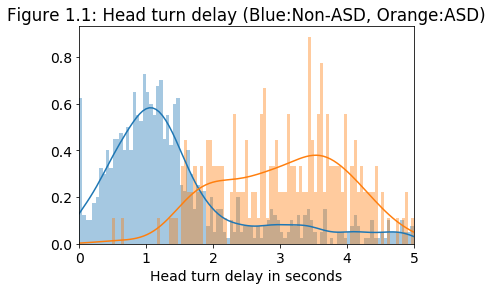

In [166]:
df = pd.DataFrame({'X':X,'Y':Y}); sns.distplot(df.query('Y==0')['X'],bins=100, kde=True); sns.distplot(df.query('Y==1')['X'],bins=100, kde=True); 
plt.xlim([0,5]); plt.title('Figure 1.1: Head turn delay (Blue:Non-ASD, Orange:ASD)'); plt.xlabel('Head turn delay in seconds');

Looking at the results of Figure 1.1, the answer to Q1 seems to be YES! Head-turn delay is a descriptive biomarker**; kids in the non-ASD group seem to be turning their heads faster after a name call. Moreover, it looks that if the delay is below one second, we are almost certain the kid belongs to the non-ASD group. At the same time, for values larger of 2s, the result suggest that there is a higher chance for the kid to be on the ASD group. So, how accurate is this feature? The answer is, "it depends," we will address this formally in the following.  

_Footnote: ** This is an illustrative synthetic example, not actual data, don't take these conclusions literally._

The plots in Figure 1.1 might be miss-leading. If we look at the distribution of values of delays, it seems that for a delay of 2-3 seconds, the likelihood of the kid to be ASD is much higher than non-ASD. And we might then jump into the (wrong) conclusion: if $x_i\in[2,3]$ then $P(y_i=1)>>P(y_i=0)$ most likely he/she is ASD. This is incorrect. The previous plot is not showing the actual probability, but rather, conditional probabilities (this is going to be more clear later). 

Let see how the actual distribution of head turn delay looks in our universe of subjects:

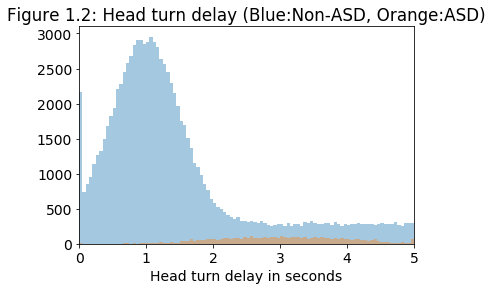

In [47]:
df = pd.DataFrame({'X':X_u,'Y':Y_u}); 
sns.distplot(df.query('Y==0')['X'],bins=100, kde=False); 
sns.distplot(df.query('Y==1')['X'],bins=100, kde=False); 
plt.xlim([0,5]); plt.title('Figure 1.2: Head turn delay (Blue:Non-ASD, Orange:ASD)'); 
plt.xlabel('Head turn delay in seconds');

When we look at the actual histograms, we see that, even for delays in the interval \[2-3\] seconds, the probability of the kid of being non-ASD is significantly larger than being ASD. This happens because the vast majority of the kids are on the non-ASD group (in this example, we set the proportion of ASD samples as 5% of the population). Working with this kind of problem is challenging, and they are usually framed as "imbalanced problems." Imbalanced means that one of the classes is much more frequent than the other. Classes imbalance poses challenges in particular, on how we measure performance (we will discuss performance measures in detail in the following). For example, let say we always label kids as non-ASD (without even looking at the value of $x$). We would be right 95\% of the time! But, of course, that solution is useless. 

At this point, two important conclusions should be taken. (1) The proportion of ASD/non-ASD kids matters when we want to make conclusions. And a warning: the ratio in our "lab" dataset might not represent the actual proportion in the universe. (2) Performance metrics need to be carefully selected (we will address this in Section X).    

(1) Can be formalized using bayes ideas [1, 7]. Bayes theorem (one of the pillars of machine learning) states:
$$
P(Y|X) = \frac{P(X|Y)P(Y)}{P(X)}.
$$

In our illustrative example, this theorem reads as: "the probability of a subject being in the ASD group, given that I observed a delay value of 2s, is proportional to the probability of kids on the ASD group to present a delay of 2s, times the probability of finding an ASD if I pick a kid at random from the entire population." This equation is useful because it shows the role of priors explicitly. $P(X|Y)$ is what we are showing in Figure 1.1 (for $Y=1$ in orange and $Y=0$ in blue), and the probability $P(X|Y)P(Y)$ is illustrated in Figure 1.2. 

In general, we only care about the value of $P(Y=1|X)$ relative to the value of $P(Y=0|X)$, this is, we don't really care about the actual probability but rather, given a measure of "x" is $P(y=1|x)>>P(y=0|x)$, $P(y=1|x)\approx P(y=0|x)$, or $P(Y=1|X)<<P(Y=0|X)$. In the first case we might conclude "most likely this kid is ASD", in the second "I don't really know", and in the third, "This kids most likely isn't ASD." 

A formal way of measuring the relative probability, is to compute 
$$
\frac{P(Y=1|X)}{P(Y=0|X)} = \frac{P(X|Y=1)P(Y=1)}{P(X|Y=0)P(Y=0)}.
$$
For example, if $\frac{P(Y=1|X)}{P(Y=0|X)}=2$, it means that given this value of "X" the probability of the subject to be in the ASD group is twice the probability of being in the non-ASD group. Notice that, in the case "X" has no information about "Y" (i.e., we are measuring a feature that is useless, e.g., the number of letters in the kid name)
$$
\frac{P(Y=1|X)}{P(Y=0|X)} \rightarrow \frac{P(Y=1)}{P(Y=0)}.
$$
This is, the probability of a kid to be in the ASD group is simply the proportion of ASD kids in the population. In this example, we set $P(Y=1)=5\%$ and $P(Y=0)=95\%$, and therefore $P(Y=1)/P(Y=0)=0.052$, this means, the probability of "discovering an ASD kid" at random is very low. Using this information as a baseline, one might want to ask, if we measure a feature "X," how much better this is than guessing at random. We can formalize this idea as 
$$
\frac{\frac{P(Y=1|X)}{P(Y=0|X)}}{\frac{P(Y=1)}{P(Y=0)}} = \frac{P(X|Y=1)}{P(X|Y=0)}.
$$
This equation is interesting because the right side is "how much better this feature gets us compared to a random guess." Meanwhile, the right term is available: is what we measure in the clinic! (e.g., is illustrated in Figure 1.1). Also, we don't have to worry about the priors, nor the fact that the proportion of ASD kids in our lab isn't the same as in the entire population.

Figure 1.3 shows the quantity $\frac{P(X|Y=1)}{P(X|Y=0)}$ for our toy example "head-turn delay".

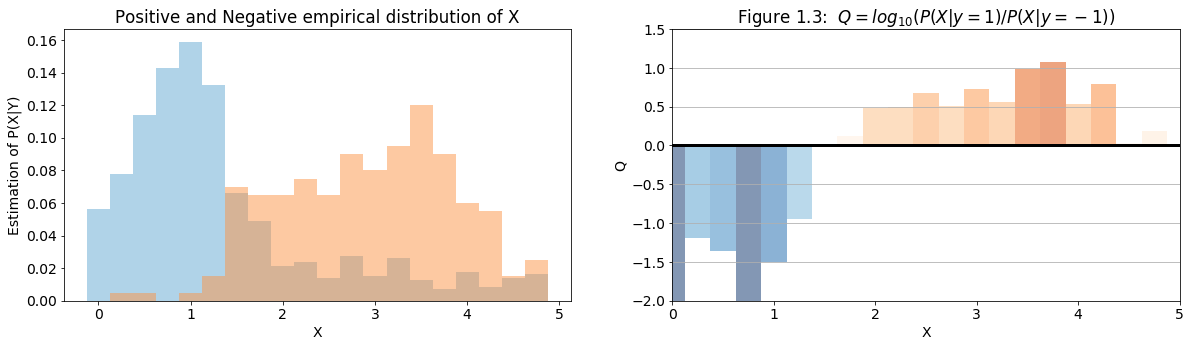

In [167]:
from stats import feature_values_positive_to_negative_ratio
Xp = X[Y==1]; Xn = X[Y==0]
Q = feature_values_positive_to_negative_ratio(Xp=Xp, Xn=Xn, verbose=1, num_bins=20)
plt.gca().set_title('Figure 1.3:  ' + plt.gca().get_title());

This type of analysis has more information than a "p-value" like approach (we will discuss those approaches latter). For example, a hypothesis test can answer the questions: Are the distributions $P(X|Y=1)$ and $P(X|Y=-1)$ the same? Do the distributions $P(X|Y=1)$ and $P(X|Y=-1)$ have the same mean? As we will see in the following section, a hypothesis test will answer for this example: these distributions are not the same, and they have a different mean. This translated to "the feature you are measuring makes sense, and is in principle, useful for the screening of ASD." However, it doesn't give any information regarding the accuracy of the tool once a value of the feature is observed. 

For example, observing a delay of 0.5 seconds, we can be almost certain that this kid belongs to the non-ASD group. In contrast, if we observe a delay of 1.5 seconds, we are not that sure about what to conclude. This information is formally provided in the expression presented above. Figure 1.3 provides the ratio  
$$
\frac{\frac{P(Y=1|X)}{P(Y=0|X)}}{\frac{P(Y=1)}{P(Y=0)}} = \frac{P(X|Y=1)}{P(X|Y=0)}.
$$
in logarithmic scale (we truncated the values to -2 and +1.5), let us call this quantity $Q$ for compactness. For example, $Q(3)=0.7$ means that if we select the group of kids for which the head turn delay is 3 seconds, and we take random samples, we are $10^{0.7}\approx 5$ times more likely to sample kids from the ASD group compared to sampling at random on the population. In contrast, values of $Q(x)$ close to $0$ indicate that the observed value does not provide any actual information. If we sample out of the kids in that group, we will obtain a similar performance as if we randomly sample from the population. Notice that both positive and negative values (far from 0) give valuable information. Positive values indicate that we have a _concentration_ of ASD (in other words, it indicates evidence of ASD), while negative values a _concentration_ of non-ASD (evidence for non-ASD).   

#### Useful performance measures for imbalance problems
Let assume after analysis, we decide we will predict ASD versus non-ASD labels depending on the kid's head turn delay after a name call. For example, we can define $\hat{y} \stackrel{def}{=} x>2$, this is, $\hat{y}=1$ for all the kids which response is slower than two seconds, and $\hat{y} = 0$ for all the kids which response is faster or equal than two seconds. Recall that for each participant we have their ground truth label $y=1$ if they are in the ASD group, $y=0$ if they are in the non-ASD group. 

Four quantities fully describe the performance of a classification algorithm: number of true positive (TP), true negative (TN), false positive (FP), and false negative (FN). The TP is define as the number of subject for which $y=1$ and $\hat{y}=1$, TN the number of subject for which $y=0$ and $\hat{y}=0$, FP the number of subject for which $y=0$ and $\hat{y}=1$ and finally, FN the number of subjects for which $y=1$ and $\hat{y}=0$. 

Some useful metrics for the evaluation of classifiers are: Accuracy $\frac{TP+TN}{TP+TN+FP+FN}$, others? As we discussed earlier, measures such as the accuracy are not suited for imbalance problems. Instead, appropriate metrics are: recall $\frac{TP}{TP+FN}$ (a.k.a sensitivity, true positive rate), precision $\frac{TP}{TP+FP}$ (a.k.a. positive predictive value), f-value (which is a weighted average between recall and precision), true negative rate $\frac{TN}{TN+FP}$, or false positive rate $\frac{FP}{FP+TN}$. Another family of metrics provides information about a "family" of solutions rather than the performance on particular operation points. For example, the ROC curve shows the false positive rate (horizontal axis) versus the true positive rate (vertical axis). It is important to notice that the ROC curve does not provide the performance of a particular implementation. (There is no particular fixed labels nor fixed values for the TP, TN, FP, and FN). Instead, it shows a "family" of solutions when one hyper-parameter (typically a classification threshold) varies. To overcome this limitation, measures such as the area under the roc curve (AUC) have been proposed.

_Warning_:  If the proportion of positive and negative samples in the dataset is different from the ratio in the entire population (which in general happens in the clinic), some of the measures listed above will be skewed. To have an accurate performance estimation, this issue should analyzed. (Maybe later we add a section on how to address this issue, for now at least take this warning into account). 

### Summary
We discussed the role of priors, and why measuring "detection" in problems with imbalance classes is not trivial. We discussed how Bayes's ideas provide a possible framework to formalize and explain these concepts. We showed that it is essential to add to the extracted features, confidence measures with a probabilist and interpretable meaning. 

So far, we assumed we could approximate $P(X|Y)$ by measuring the "histogram" of the observed values of $X$ over an empirical sample. Section 2 formalizes this concept and discusses how to calculate the estimation error and confidence intervals. The previous discussion is very informative but is somehow complicated. Sometimes we just want to know, is X a useful feature or not? This kind of "binary" question is answered with hypothesis testing, which we discuss in Section 3. 

## Section 2: Estimation of PDFs and parameters
- 2.1: Approximation of Probability Distributions.
- 2.2: Parameter estimation. 
- 2.3: The Bootstrap.

In Section 1, we discussed how to use the marginal probabilities $P(X|Y)$ to asses the diagnosis power of a feature "X" and, in particular, how to correctly measure performance in the context of imbalanced classes. During the discussion of Section 1, we assumed $P(X|Y)$ was known, or more precisely, we assumed that a histogram of empirical observations was a _good approximation_ of the probability density function (PDF). This might or not be true; we need to analyze when a histogram is a good approximation of a PDF, and provide a formal numerical assessment for "_good approximation_." 

In the present section, we address most of the problems stated above. We provide quantitative indications of when a histogram is a good approximation of a PDF, and we show how to compute the optimal number of bins (or histogram resolution). We show how to calculate confidence intervals associated with empirical histograms. Also, we discuss the "Bootstrap" method, which is arguably one of the most robust and versatile techniques to estimate confidence intervals. Finally, we discuss the problem of distribution parameters estimation. 

### Section 2.1: Approximation of PDFs and CDFs

#### Definition 2.1: CDF 
Let $X_1,...,X_n \sim F$ be an IID sample with distribution $F$. IID means "independent identically distributed," i.e., all the samples are independent realizations of the same phenomenon. For example, consider the illustrative case introduced in Section 1. We measure for $n$ kids in the ASD group their head-turn delay after a name call. All these events will be independent to each other, and all can be seen as a realization of the distribution $F$. The CDF $F(x)$ is formally defined as $P(X\leq x)$, in this example, the probability that a random ASD kid responds with a delay less than or equal to $x$. $F$ is unknown in practice, but in this toy example, we are generating samples, and therefore we know it. Since we have two different groups, we have two distributions $F_{ASD}$ and $F_{non-ASD}$. In this section, we are not focusing on differentiating, but rather, on how well we can approximate each. Hence, for the rest of the section, let us focus on a single one, for example, $F\stackrel{def}{=}F_{ASD}$. 

The **empirical distribution function** $\hat{F}$ is defined as:
$$
\hat{F}(x) = \frac{1}{n} \sum_{i=1}^{n} I(X_i \leq x)
$$
where $I(X_i \leq x) = 1$ if $X_i\leq x$, $0$ otherwise.

For example, Figure 2.1 shows for our toy example, the ground truth, and the empirical CDF estimated for 10, 20, and 200 observed samples. 

           Figure 2.1: Empirical approximation of the CDF


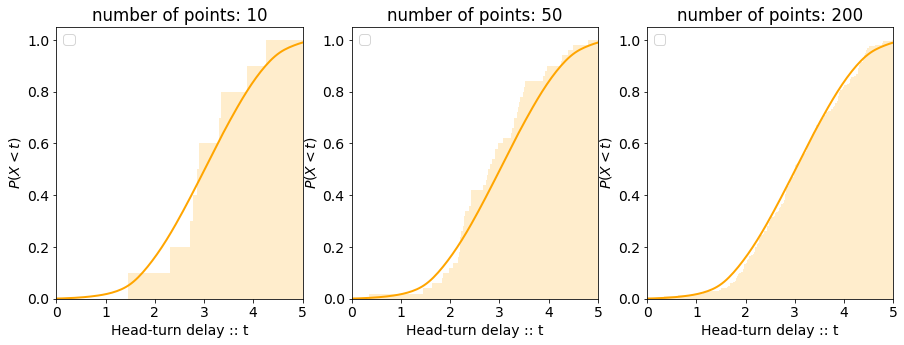

In [49]:
print(color.BOLD + '           Figure 2.1: Empirical approximation of the CDF' + color.END)
plt.figure(figsize=[15,5])
# In addition plot the empirical distribution for different number of datapoints. 
num_bins = 200; xmin = 0; xmax=5; n = len(Xp)
h = (xmax-xmin)/ num_bins;  # bin size

ns = [10,50,200]
for (i,n) in enumerate(ns):
    plt.subplot(1,3,i+1)
    # Plot the ground truth comulative distribution (formally is an approximation with a lot of empirical points)
    sns.kdeplot(df.query('Y==1')['X'], cumulative=True, linewidth=2, color='orange');

    x = Xp[:n]  # Sample n points
    # Count empirical points per-bin 
    count, edges = np.histogram(x, range=[xmin, xmax], bins=num_bins)  
    # Convert count to an estimation of the prob(x in B)
    prob_bin = count/n
    # Convert from prob in interval to pdf (int(pdf)_B = proba_B)
    pdf = prob_bin/h  
    # Compute the comulative probability
    cdf = prob_bin.cumsum()
    plt.bar(edges[:-1]+h/2, cdf, width=h, color='orange', alpha=.2)
    plt.xlim([0,5]); plt.xlabel('Head-turn delay :: t'); plt.ylabel('$P(X<t)$')
    plt.legend([]); plt.title('number of points: {}'.format(n));

#### Definition 2.2: PDF 
Similar to the CDF, the probability density distribution (PDF) is defined as:
$$
f(x) \stackrel{def}{=} \lim_{\delta\rightarrow 0} \frac{P(x\leq X < x+\delta)}{\delta} = \lim_{\delta\rightarrow 0} \frac{F(x+\delta)-F(x)}{\delta} = F'(x).
$$

We will skip all the mathematical technicalities and assume all the limits introduced above exist (i.e., the CDFs considered are differentiable everywhere). Also, we will consider in all the practical applications we are working with, the CDFs are "smooth." While $F(x)$ has a very intuitive meaning: "the probability that $X$ is lower than $x$," the interpretation of $f(x)$ is more difficult. $f(x)$ can be understood as the derivative of $F$, but was no probabilist meaning unless we integrate it in a interval, i.e., $P(x\in A) = \int_A p(x)\,dx$. 

As we will see in the following, discrete approximations can be obtained for $F(x)$ and $f(x)$. As we will discuss, **estimating the error and confidence intervals associated with the approximation of $F$ is substantially simpler than $f$.** For example, look at the approximations shown in Figure 2.1, $\hat{F}$ looks quite similar to $F$ (when we have a decent amount of data). However, do you think $\hat{F} '(x)$ is similar to $F'(x)$? The answer is **NO**, and this is why working with $f$ is harder. As we will see, to approximate $f$, we will have to add the hypothesis that "F" is smooth. (Luckily for us, this hypothesis makes sense in most of the variables we will measure across this project.) 

#### Estimating the CDF and its confidence intervals
As we discussed in Definition 2.1, estimating the CDF is quite straight forward. The **empirical distribution function** $\hat{F}$ is defined as:
$$
\hat{F}(x) = \frac{1}{n} \sum_{i=1}^{n} I(X_i \leq x)
$$
where $I(X_i \leq x) = 1$ if $X_i\leq x$, $0$ otherwise.

It can be proved (Theorem 7.3 ref. [1]) that at any fixed value of $x$,
- $\mathbf{E}(\hat{F}(x)) = F(x)$,
- $\displaystyle\mathbf{V}(\hat{F}(x)) = \frac{F(x)(1-F(x))}{n}$.  

These properties are general (no assumptions are made about $F$). Despite showing that the estimation makes sense (i.e., it will give as the right value as the number of samples increases), the previous expressions are of little practical advantage. The variance of $\hat{F}$, $V(\hat{F})$, could be used to compute confidence intervals; however, notice that to calculate it, we need $F$ (which is what we were trying to estimate in the first place!). 

In order to compute confidence intervals associated to $\hat{F}$, we can exploit Dvoretzky-Kiefer-Wolfowitz inequality. Let $X_1, ..., X_n \sim F$, then for any $\epsilon>0$, 
$$
P\left(\sup_{x}|F(x)-\hat{F}(x)|>\epsilon\right)\leq 2e^{-2n\epsilon^2}.
$$
From DKW inequality, we can construct a confidence interval for $\hat{F}$ as follows.

**Empirical CDF estimation confidence interval:**
Define $L(x) = \max\{\hat{F}-\epsilon,0\}$ and $U(x) = \min\{\hat{F}+\epsilon, 1\}$, where 
$$\epsilon = \sqrt{\frac{1}{2n}\log\left(\frac{2}{\alpha}\right)}.$$
It follows from DKW that (for any $F$), 
$$P\left(L(x) \leq F(x) \leq U(x) \ \ \mbox{for all } x \right) \geq 1 - \alpha.$$

In [51]:
# This are the importan pieces of code:  (check "estimate_cdf" in stats.py)
alpha = 0.05  # Set for example, a 5% confidence interval
cdf_epsilon = lambda n, alpha: np.sqrt( (1/(2*n)) * np.log(2/alpha) )
U = lambda hatF, epsilon: min(hatF + epsilon, 1)
L = lambda hatF, epsilon: max(hatF - epsilon, 0)

           Figure 2.2: Empirical approximation of the CDF and confidence intervals


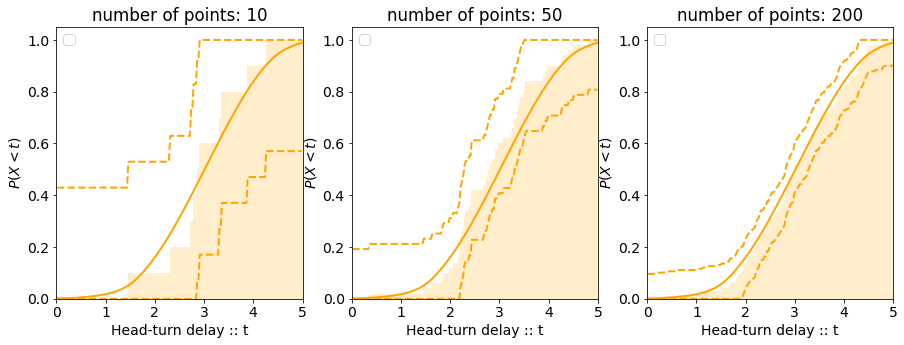

In [52]:
from stats import estimate_cdf
print(color.BOLD + '           Figure 2.2: Empirical approximation of the CDF and confidence intervals' + color.END)
plt.figure(figsize=[15,5])
# In addition plot the empirical distribution for different number of datapoints. 
num_bins = 200; xmin = 0; xmax=5; n = len(Xp)

ns = [10,50,200]
for (i,n) in enumerate(ns):
    plt.subplot(1,3,i+1)
    # Plot the ground truth comulative distribution (formally is an approximation with a lot of empirical points)
    sns.kdeplot(df.query('Y==1')['X'], cumulative=True, linewidth=2, color='orange');

    x = Xp[:n]  # Sample n points
    hatF, l, u = estimate_cdf(x, num_bins=num_bins, alpha=0.05, xmin=xmin, xmax=xmax, verbose=1)
    plt.xlim([0,5]); plt.xlabel('Head-turn delay :: t'); plt.ylabel('$P(X<t)$')
    plt.legend([]); plt.title('number of points: {}'.format(n));

Figure 2.2 shows the estimation $\hat{F}$ of the distribution $F$, for datasets of different size. In addition the 95% confident interval associated to each of these estimations is illustrated. 

#### Estimating the PDF and its confidence intervals

We discussed that estimations of $F$ could be obtained without any explicit assumptions about $F$. On the other hand, estimating the density probability distribution $f$ requires some hypothesis about the regularity of the PDF. 

The simplest density estimator is a histogram. As before, let $X_1, ..., X_n$ be IID with density $f$ ($f=F'$), let assume the $X_i$ is restricted to the interval $[x_{min}, x_{max}]$, and let partition this interval into $m$ bins. The bin size $h$ can be computed as $h= (x_{max}-x_{min})/m$, the more bins (larger $m$) the smaller the bins size and vice-versa. 

Figure 2.3 illustrates the histograms computed from $50$ empirical ASD samples of our toy head-turn delay example. We show the resulting histograms for three numbers of bins. Also (solid line), the ground truth PDF is plotted. 

           Figure 2.3: Empirical approximation of the PDF


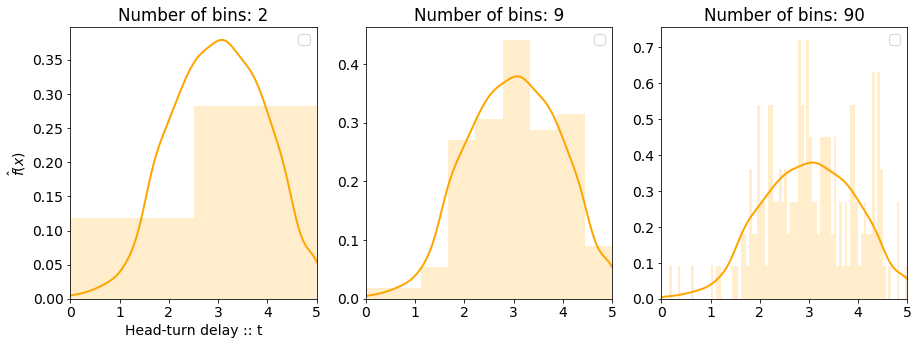

In [53]:
# Impact of the bin size on the estimation error. 
print(color.BOLD + '           Figure 2.3: Empirical approximation of the PDF' + color.END)
plt.figure(figsize=[15,5])
# In addition plot the empirical distribution for different number of datapoints. 
xmin = 0; xmax=5; n = 200
x = Xp[:n]  # Sample n points

num_bins_set = [2,9,90]
for (i,num_bins) in enumerate(num_bins_set):
    h = (xmax-xmin)/ num_bins;  # bin size

    plt.subplot(1,3,i+1)
    # Plot the ground truth comulative distribution (formally is an approximation with a lot of empirical points)
    sns.kdeplot(df.query('Y==1')['X'], cumulative=False, linewidth=2, color='orange');

    # Count empirical points per-bin 
    count, edges = np.histogram(x, range=[xmin, xmax], bins=num_bins)  
    # Convert count to an estimation of the prob(x in B)
    prob_bin = count/n
    # Convert from prob in interval to pdf (int(pdf)_B = proba_B)
    pdf = prob_bin/h  
    
    plt.bar(edges[:-1]+h/2, pdf, width=h, color='orange', alpha=.2)    
    if i == 0:
        plt.xlabel('Head-turn delay :: t'); plt.ylabel('$\hat{f}(x)$');
    plt.legend([]); plt.title('Number of bins: {}'.format(num_bins)); plt.xlim([0,5]);

To estimate $\hat{f}$, we first define the set of bins $\mathcal{B} = \{B_1, ..., B_m\}$. In our toy example, the bins are simply the intervals $B_i = (x_{min} + h(i-1), x_{min} + hi]$. The probability of $X$ to be in $B_i$ can be estimated as $$\hat{p}_i = \frac{1}{n} \sum_{i=1}^n I(X_i \in B_i),$$ 
and the pdf estimator $\hat{f}$ by
$$\hat{f}(x) = \left\{\begin{array}{l}
\hat{p}_1/h  \ \ x\in B_1 \\ 
\hat{p}_2/h  \ \ x\in B_2 \\ 
... \\
\hat{p}_m/h  \ \ x\in B_m \\ 
\end{array}\right. .$$ 

Before discussing confidence intervals associated with these estimations, let us focus on the estimation error. As we can see (e.g., comparing figures 2.1 and 2.3), estimating $\hat{f}$ requires setting the bin size. A small number of bins (first example in Figure 2.3) would fail to accurately approximate $f$ do to the lack of spatial resolution. On the other extreme (third example in Figure 2.3), too many bins would produce quantities prone to error (since only a few points lie in each segment). 

The problem discussed above can be formalized as follows. The integrated squared error (ISE) for the estimation $\hat{f}$ can be defined as:
$$
L\left(f, \hat{f}\right) = \int \left( f(x)-\hat{f}(x) \right)^2 dx. 
$$
The risk or mean integrated squared error (MISE) is, 
$$
R\left(f, \hat{f}\right) = \mathbf{E}\left(L\left(f, \hat{f}\right)\right).
$$

**Lemma 2.1 ([1] pag. 304)** The risk can be written as
$$
R\left(f, \hat{f}\right) = \int{b^2(x) dx} + \int{v(x) dx}
$$
where $b(x) = \mathbf{E}\left(\hat{f}(x)-f(x)\right)$ is the bias of $\hat{f}$ (at $x$), and $v(x) = \mathbf{V}\left(\hat{f}(x)\right)$ is the variance of the estimated value at $x$, $\hat{f}(x)$. 

> **RISK = BIAS$^2$ + VARIANCE**

If we set bins that are too large, the bias will be too large (making the risk high and the prediction weak). If we set the bins too small, the variance on the estimation will be too noisy, dominating the risk and also producing a poor estimator. **We need to set the number of bins, such that the risk is minimized** (or at least close to a minimum). 




#### Setting the optimal number of histograms

One might try to set the optimal number of bins $m^*$ by minimizing the risk function defined above. However, this is impractical because we need the ground truth $f$ to compute the error (so is like a chicken and egg problem). Instead, we will solve an approximation of the error loss function. 

$$
L(f,\hat{f}) = \int\left(\hat{f}(x)-f(x)\right)^2 dx = \int \hat{f}^2(x) dx - 2\int \hat{f}(x)f(x) dx + \int f^2(x) dx, 
$$
the last term doesn't depend on $m$ so minimizing the risk is equivalent to minimizing the expected value of 
$$
J(f, \hat{f}) = \int \hat{f}^2(x) dx - 2\int \hat{f}(x)f(x) dx.
$$
We shall refer now to $\mathbf{E}(J)$ as the risk (thought formally it differs from it by a constant term). The cross-validation estimator for the risk is 
$$
\hat{J}(\hat{f}) = \int \left( \hat{f}(x) \right)^2 dx - \frac 2 n \sum_{i=1}^{n} \hat{f}_{(-i)}(X_i)
$$
where $\hat{f}_{(-i)}$ is the histogram estimator obtained after removing the $i^{th}$ observation. 

**Theorem 2.1 ([1] pag. 310)** The following identity holds:
$$
\hat{J}(\hat{f}) = \frac{2}{(n-1)h} - \frac{n+1}{(n-1)h}\sum_{i=1}^{m} \hat{p}_i^2. 
$$

Theorem 2.1 is practical, as it can be easily computed to estimate the optimal number of bins, as we illustrate in the following example. 

_**WARNING:** in [1] the definition is incorrect in Eq. (20.14). $h$ is missing in the second term, I checked with the original reference* where is correct Eq. (2.8) *Mats Rudemo. Empirical Choice of Histograms and Kernel Density Estimators. 1981_

In [56]:
# To optimize the number of bins, we can use this expresion: (check bin_size_risk_estimator for more details).
def hat_J(hat_p, n): 
    """
    Compute the cross-validation estimator of the risk. 
    hat_p: is N_i/n, where N_i is the number of datapoints in the ith bin
    n: is the number of datapoints
    """
    m = len(hat_p)  # the number of p_i is the number of bins. 
    h = 1/m  # When theorem 2.1 is obtained, the data is assumed to be mapped to the range [0,1]
    # therefore, when m bins are selected, the bin width is h=1/m
    J = 2 / ((n-1)*h) - (n+1) / (n-1) / h  * np.sum(np.square(hat_p))
    return J

           Figure 2.4: Risk approximation and optimal number of bins


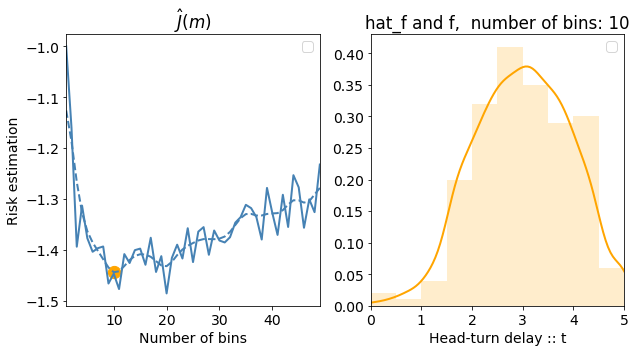

In [62]:
print(color.BOLD + '           Figure 2.4: Risk approximation and optimal number of bins' + color.END)
plt.figure(figsize=[10,5])

xmin = 0; xmax=5; n = 200
x = Xp[:n]  # Sample n points

from stats import bin_size_risk_estimator
plt.subplot(1,2,1)
hat_J, opt_num_bins = bin_size_risk_estimator(x, num_bins_range=[1,50], xmin=xmin, xmax=xmax, verbose=1)

plt.subplot(1,2,2)
sns.kdeplot(df.query('Y==1')['X'], cumulative=False, linewidth=2, color='orange');  # plot grount truth
num_bins = opt_num_bins; h = (xmax-xmin)/ num_bins;  # bin size
count, edges = np.histogram(x, range=[xmin, xmax], bins=num_bins)  
prob_bin = count/n; pdf = prob_bin/h; plt.bar(edges[:-1]+h/2, pdf, width=h, color='orange', alpha=.2)    
plt.xlim([0,5]); plt.xlabel('Head-turn delay :: t'); 
plt.legend([]); plt.title('hat_f and f,  number of bins: {}'.format(num_bins));

#### Estimating confidence intervals associated to the estimated pdf

Now that we know how to estimate the optimal number of bins given empirical observations, we will address which are the confidence intervals associated to $f$. Suppose $\hat{f}$ is a histogram with $m$ bins and binwidth $h=1/m$. We will define $\bar{f}=p_i/h$ where $p_i = \int_{B_i} f(x)dx$. As before, $B_i$ represents the interval associated to the $i^{th}$ bin of the histogram. $\bar{f}$ represents the ground truth "histogram version" of the pdf $f$. 

A pair of functions $(l(x), u(x))$ is a $1-\alpha$ confidence band if, 
$$
\mathbf{P}\left( l(x) \leq \bar{f}(x) \leq u(x) \mbox{ for all } x \right) \geq 1-\alpha
$$

**Theorem 2.2 ([1] pag.311)** Let $m(n)$ be the number of bins in the histogram $\hat{f}$. Assume $m(n)\rightarrow 0$ and $m(n)\frac{\log(n)}{n}\rightarrow 0$ as $n\rightarrow \infty$. Define 
$$
l(x) = \left(\max\left\{ \sqrt{\hat{f}(x)} -c, 0\right\} \right)^2
$$
$$
u(x) = \left(\sqrt{\hat{f}(x)} + c \right)^2
$$
where 
$$
c = \frac{z_{\alpha/(2m)}}{2}\sqrt{\frac{m}{n}}.
$$

Then, $(l(x),u(x))$ is an approximate $1-\alpha$ confidence band. 

In [71]:
# Important code for implementation (see compute_histogram_and_conf_interval)
def compute_hist_conf_constant(alpha, m, n):   
    def z_u(u):  # Compute the upper u quantile of N(0,1)
        from scipy.stats import norm
        z = norm.ppf(1-u)  # z_u = Phi^-1(1-u)  with Phi = cdf_{N(0,1)}
        return z
    c = z_u(alpha/(2*m))/2 * np.sqrt(m/n)
    return c

lf = lambda hat_f,c: (max( np.sqrt(hat_f)-c, 0 ))**2
uf = lambda hat_f,c: (np.sqrt(hat_f)+c)**2

           Figure 2.5: Empirical approximation of the PDF with 5-95\% confidence intervals


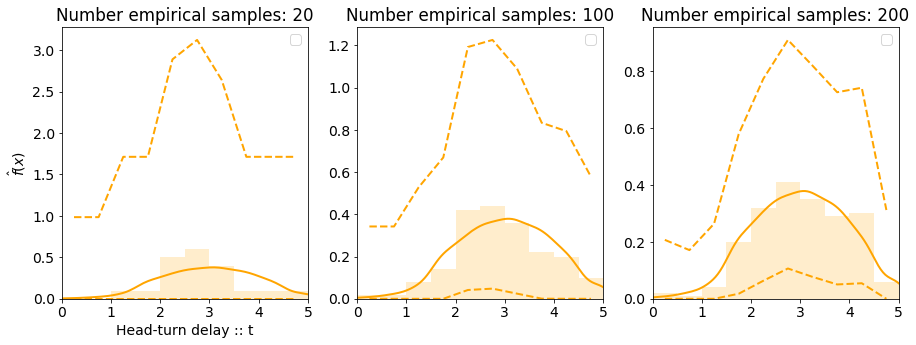

In [97]:
# Impact of the bin size on the estimation error. 
from stats import compute_histogram_and_conf_interval
print(color.BOLD + '           Figure 2.5: Empirical approximation of the PDF with 5-95\% confidence intervals' + color.END)
plt.figure(figsize=[15,5])
# In addition plot the empirical distribution for different number of datapoints. 
xmin = 0; xmax=5; num_bins = 10; alpha = 0.05 # Conf interval
 
ns = [20, 100, 200]
for (i,n) in enumerate(ns):
    x = Xp[:n]  # Sample n points
    
    plt.subplot(1,3,i+1)
    sns.kdeplot(df.query('Y==1')['X'], cumulative=False, linewidth=2, color='orange');

    # Count empirical points per-bin 
    hat_f, l, u = compute_histogram_and_conf_interval(x, xmin=xmin, xmax=xmax, alpha=alpha, 
                                                      num_bins=num_bins, verbose=1)
    if i == 0:
        plt.xlabel('Head-turn delay :: t'); plt.ylabel('$\hat{f}(x)$');
    plt.legend([]); plt.title('Number empirical samples: {}'.format(n)); plt.xlim([0,5]);

Figure 2.5 shows the ground truth $f$, and the estimated $\hat{f}$ from 20, 100, and 200 empirical samples. We used the optimal bin size estimated above. In addition, the $5\%-95\%$ confidence interval associated with each estimation is displayed. 

As we can see, the intervals get narrower as the number of samples increases. Even for 200 samples, the uncertainty bounds estimated seem quite large; tighter estimations can be obtained using "kernel" based methods, which we will address next. 

#### Kernel-based density estimation 

Kernel density estimators are smoother and converge faster to the true distributions, i.e., they are more accurate the for same amount of empirical data, and provide tighter confidence intervals). As above $X_1, ..., X_n$ are IID samples from $f$. Given a kernel $K$ and a positive number $h$ (called _the bandwidth_), the kernel density estimator is defined 
$$
\hat{f}(x) = \frac{1}{n} \sum_{i=1}^{n} \frac 1 h K\left(\frac{x-X_i}{h}\right).
$$

To construct a kernel density estimator we need to choose a kernel $K$ and a bandwidth $h$. It can be shown that the selection of $h$ is important while the choice of $K$ isn't crucial [1]. Here, we will use the Gaussian kernel: 
$$
\displaystyle K(u) = \frac{1}{\sqrt{2\pi}} e^{\frac{-u^2}{2}}. 
$$

Figure 2.6 shows the kernel density estimator for our head-turn example. 

In [120]:
# Example of a kernel estimation implementation 
def kernel_estimator(X,x=None,h=1):
    K = lambda u: 1/np.sqrt(2*np.pi) * np.exp(-u**2 / 2)
    n = len(X)  # number of samples    
    hat_f = np.zeros_like(x)  # init.
    for j, x_j in enumerate(x):
        for X_i in X:
            hat_f[j] += 1/(n*h) * K( (x_j-X_i) / h )
    return hat_f

           Figure 2.6: Kernel approximation of the PDF (200 datapoints).


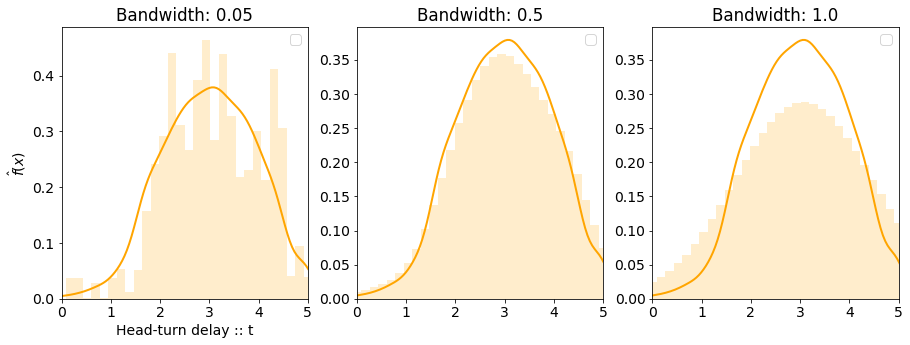

In [121]:
from stats import kernel_estimator
# Impact of the bin size on the estimation error. 
print(color.BOLD + '           Figure 2.6: Kernel approximation of the PDF (200 datapoints).' + color.END)
plt.figure(figsize=[15,5])
# In addition plot the empirical distribution for different number of datapoints. 
xmin = 0; xmax=5; n = 200; X = Xp[:n] 
h0 = (xmax-xmin)/10  # Bandwidth
N = 30  # x resolution for the estimation of the kernel. 
x = np.linspace(xmin,xmax,N)  # Define the points in which the density is estimated. 

h_set = [h0/10,h0,2*h0]  # Define the set of bandwidths.
for (i,h) in enumerate(h_set):
    plt.subplot(1,3,i+1)
    # Plot the ground truth comulative distribution (formally is an approximation with a lot of empirical points)
    sns.kdeplot(df.query('Y==1')['X'], cumulative=False, linewidth=2, color='orange');
    # Count empirical points per-bin 
    hat_f = kernel_estimator(X,x=x,h=h)
    plt.bar(x, hat_f, width=x[1]-x[0], color='orange', alpha=.2)    
    if i == 0:
        plt.xlabel('Head-turn delay :: t'); plt.ylabel('$\hat{f}(x)$');
    plt.legend([]); plt.title('Bandwidth: {}'.format(h)); plt.xlim([0,5]);

As we illustrate in Figure 2.6, the bandwidth $h$ plays a similar role compared to the number of bins in the histogram estimation. The smaller the bandwidth, the larger the error because of variance. The larger the bandwidth, the larger the error because of bias. As for the number of bins, we need to estimate the optimal bandwidth by minimizing the approximation error. Recall that:
> **RISK = BIAS$^2$ + VARIANCE**

The cross-validation estimation of the risk $\hat{J}(h)$ can be approximated using Theorem 2.3.

**Theorem 2.3 ([1] pag. 316)** For any $h>0$, $\mathbf{E}[\hat{J}(h)] = \mathbf{E}[J(h)]$, and 
$$
\hat{J}(h) \approx \frac{1}{h n^2}\sum_{i}\sum_{j} K^*\left(\frac{X_i-X_j}{h}\right) + \frac{2}{nh}K(0)
$$
where $K^*(u) = K^{(2)}(u)-2 K(u)$ and $K^{(2)}(z) = \int K(z-y)K(y)dy$. In particular, if $K$ is $N(0,1)$, then $K^{(2)}$ is the $N(0,2)$ density. 

Figure 2.7 shows the estimated risk (left) and the estimated density for the optimal bandwidth. 

In [123]:
def kernel_based_empirical_risk(X, h):
    # Define shortcuts for K K2 and K_ast
    K = lambda u: 1/np.sqrt(2*np.pi) * np.exp(-u**2 / 2)  # Define the kernel N(0,1)
    K2 = lambda u: 1/np.sqrt(2*np.pi * 2) * np.exp(-u**2 / (2 * 2))  # Define the kernel with sigma^2=2
    K_ast = lambda u: K2(u) - 2*K(u)    
    n = len(X)
    J = 2/(n*h) * K(0)  #  Left term [1] pag. 316, Eq (20.25)
    for X_i in X:
        for X_j in X:
            J += 1 / (h * n**2) * K_ast( (X_i-X_j) / h )
    return J

           Figure 2.7: Bandwidth optimization.


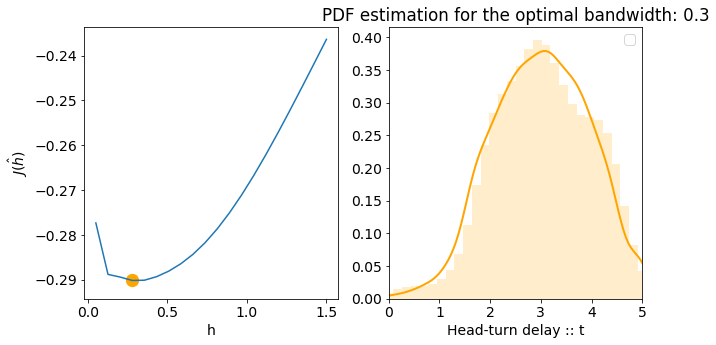

In [138]:
from stats import kernel_estimator
# Impact of the bin size on the estimation error. 
print(color.BOLD + '           Figure 2.7: Bandwidth optimization.' + color.END)
plt.figure(figsize=[10,5])
# In addition plot the empirical distribution for different number of datapoints. 
xmin = 0; xmax=5; n = 200; X = Xp[:n] ; N = 30  # x resolution for the estimation of the kernel. 
x = np.linspace(xmin,xmax,N)  # Define the points in which the density is estimated. 

from stats import kernel_based_empirical_risk
hs = np.linspace(0.05,1.5,20)
J = [kernel_based_empirical_risk(X,hh) for hh in hs]
plt.subplot(1,2,1); plt.plot(hs,J); plt.xlabel('h'); plt.ylabel('$\hat{J(h)}$')
h_opt = hs[np.argmin(J)]  # get opt bandwidth
plt.scatter(h_opt, min(J), 150, color='orange')
plt.subplot(1,2,2); sns.kdeplot(df.query('Y==1')['X'], cumulative=False, linewidth=2, color='orange');
hat_f = kernel_estimator(X,x=x,h=h_opt)
plt.bar(x, hat_f, width=x[1]-x[0], color='orange', alpha=.2)    
plt.xlabel('Head-turn delay :: t'); plt.xlim([0,5]);
plt.legend([]); plt.title('PDF estimation for the optimal bandwidth: {:2.1f}'.format(h_opt)); 

As for the estimated histograms, confidence intervals can be estimated for the kernel density estimation. Again, the confidence band is defined for a smoothed version $\bar{f}$ of the ground truth distribution $f$, In this case, defined as
$$
\bar{f}(x)=\int{\frac 1 h K \left( \frac{x-u}{h} \right) f(u)\, du } \ = \mathbf{E}(\hat{f}(x).
$$

When the normal kernel is used, a $1-\alpha$ confidence interval $(l(x),u(x))$ is given by
$$
l(x) = \hat{f}(x)- q\, \mbox{se}(x), u(x) = \hat{f}(x) + q\, \mbox{se}(x)
$$
where 
$$
\mbox{se}(x) = \frac{s(x)}{\sqrt{n}}, \ \ s^2(x) = \frac{1}{n-1} \sum_i (Y_i(x) - \bar{Y}(x))^2, \ \ \left(\bar{Y}(x) = \frac 1 n \sum_i Y_i(x)\right),\ Y_i(x) = \frac{1}{h} K\left(\frac{x-X_i}{h}\right),
$$

$$
q = \Phi^{-1}\left(\frac{1 + (1-\alpha)^{1/m}}{2}\right), \mbox{ and } m=3h.
$$

Figure 2.8 shows the $95\%$ confidence interval for the kernel density estimation presented in Figure 2.6, and compare this result with the one obtained for the histogram estimator (Figure 2.5). 

In [164]:
# Example of implementation (see stats compute_kernel_estimator_and_conf_intervals for more details).
def compute_kernel_estimation_conf(X, hat_f=None, x=None, h=None, alpha=0.05):
    K = lambda u: 1/np.sqrt(2*np.pi) * np.exp(-u**2 / 2)  # Define the kernel N(0,1)
    from scipy.stats import norm
    m = 3*h
    q = norm.ppf( ( 1 + (1-alpha)**(1/m) ) / (2) )  # ppf(x) = Phi^-1(x)  Phi = cdf_{N(0,1)}
    n = len(X)
    l = np.zeros_like(hat_f); u = np.zeros_like(hat_f)  # init.
    for j,xx in enumerate(x):  # for each x coordinate compute l(x) and u(x)
        Y_i = np.array([ 1/h * K((xx-XX)/h) for XX in X]) 
        bar_Y = np.mean(Y_i)
        s_square = 1 / (n-1) * np.sum( (Y_i-bar_Y)**2 )
        se = np.sqrt(s_square) / np.sqrt(n)
        l[j] = hat_f[j] - q*se
        u[j] = hat_f[j] + q*se
    return l, u

           Figure 2.8: Density estimation and its confidence intervals.


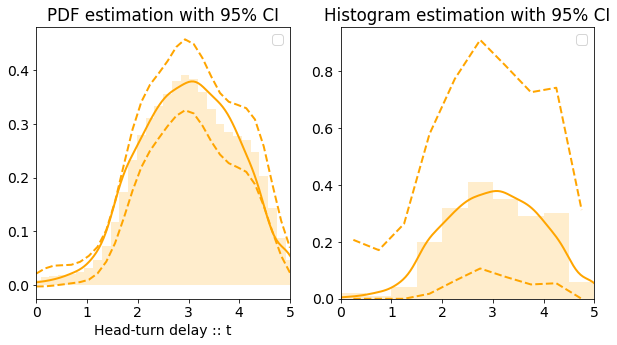

In [163]:
from stats import kernel_estimator
# Impact of the bin size on the estimation error. 
print(color.BOLD + '           Figure 2.8: Density estimation and its confidence intervals.' + color.END)
plt.figure(figsize=[10,5])
# In addition plot the empirical distribution for different number of datapoints. 
xmin = 0; xmax=5; n = 200; X = Xp[:n] ; N = 30  # x resolution for the estimation of the kernel. 
x = np.linspace(xmin,xmax,N)  # Define the points in which the density is estimated. 
alpha=0.05  # set conf. interval

from stats import compute_kernel_estimator_and_conf_interval
h = 0.3; 
plt.subplot(1,2,1); sns.kdeplot(df.query('Y==1')['X'], cumulative=False, linewidth=2, color='orange');
hat_f, l, u = compute_kernel_estimator_and_conf_interval(X,x=x,xmin=xmin,xmax=xmax,h=h,
                                                         alpha=alpha,verbose=1)
plt.xlabel('Head-turn delay :: t'); plt.xlim([0,5]); plt.legend([]); 
plt.subplot(1,2,2);  
sns.kdeplot(df.query('Y==1')['X'], cumulative=False, linewidth=2, color='orange');
hat_f, l, u = compute_histogram_and_conf_interval(X, xmin=xmin, xmax=xmax, alpha=alpha, 
                                                  num_bins=num_bins, verbose=1)
plt.title('Histogram estimation with 95% CI'); plt.legend([]); 

It seems that for the type and amount of data we handle in this project, kernel-based pdf estimation should be the choice. Kernel-based methods estimate the pdf with slightly better accuracy but provide substantially tighter confidence intervals. 

### Section 2.2: Parameter estimation
In the previous sections, we focus on how to estimate the entire distribution of a random process. We showed that the CDF $F$ and the PDF $f$ can be calculated. $F$ is, in general, easier to estimate, while additional regularization hypothesis are required to assess $f$. Also, we showed how to calculate optimal parameters and confidence intervals for both histogram-based and kernel-based PDF estimations. Once we have these estimations, we can work with arguments like the ones introduced in Section 1. 

So far, our approach has been quite ambitious. We aimed at getting a complete picture of our random process. Sometimes, we may want to answer more straightforward questions such as: what is the mean of a distribution. Recall that many different PDFs can have the same mean, so we are asking _less_ information about the process compared to before. 

Why would we want to do this if we can get the full picture by estimating the entire PDF or CDF? One reason is the lack of data, if we have restricted access to data (i.e., a small number of samples $n$), we might not be able to estimate $f$ reliably, but we could be able to reliably estimate the PDF mean $\mu = \int x f(x) dx$. Another good reason is simplicity. Sometimes we just want to prove that two distributions have a different mean, and we don't care about the shape of these distributions. For example, going back to our head-turn model, we might want to know how the **average** heat-turn delay of TD kids compare to the ASD kids. 

Questions like the one described above can be answered quantitatively estimating the parameters of a distribution (rather than the entire distribution as we did before). Another strategy to answer this type of question is to perform hypothesis testing, which we will discuss in sections 3 and 4. 

**Theorem 2.4: The Central Limit Theorem (CLT)** Let $X_1, ..., X_n$ be IID with mean $\mu$ and variance $\sigma^2$. Let $\bar{X}_n = n^{-1} \sum_{i=1}^n X_i$. Then
$$
\frac{\bar{X}_n-\mu}{\sigma / \sqrt{n}} \stackrel{n\rightarrow \infty}{\rightsquigarrow} N\left(0, 1\right).
$$

$X_n \rightsquigarrow F$ means that $X_n$ converges to $F$ _in distribution_, i.e., $\lim_{n\rightarrow \infty} F_n(x) = F(x)$ for all $x$ for which $F$ is continuous. (A formal and more exhaustive explanation is provided in [1,9].) This theorem is central to the objectives of this section. First, it tells us that a simple average of the samples is a good approximation of the mean of the distribution of $X_i$. As the number of samples increases, it tells us that the error tends to 0. It also gives an idea of the error (the variance) which, as we shall see, can be used to estimate confidence intervals. The most remarkable part is that it tells us that $\bar{X_n}$ has a normal probability distribution, with no hypothesis about $F$! (the distribution of $X_i$). 

**Theorem 2.5 ([1] pag. 78)** Assume the same conditions as in Theorem 2.4. And define, 
$$
S_n^2 = \frac{1}{n-1} \sum_{i=1}^{n}(X_i - \bar{X}_n)^2.
$$
Then, 
$$
\frac{\bar{X}_n-\mu}{S_n / \sqrt{n}} \stackrel{n\rightarrow \infty}{\rightsquigarrow} N\left(0, 1\right).
$$

Theorem 2.5 essentially tell us that we can still apply the CLT using the estimated variance $S_n$ instead of the ground truth variance $\sigma$. This is very useful, since the ground truth value of $\sigma$ is unknown in practice. Using Theorem 2.5, computing a $\alpha$ confidence interval for $\bar{X}_n$ is straightforward: $\bar{X}_n \pm z_{\alpha/2} \frac{S_n}{\sqrt{n}}$. (For $\alpha=0.05$, $z_{\alpha/2} = 1.96 \approx 2$, is common then to use the approximated rule of $\pm 2 \frac{S_n}{\sqrt{n}}$.)

**Example** What is the mean of head-turn delays for the ASD and non-ASD kids? 

In [175]:
# As before, for compactness we refer to the positive class the class of ASD kids, 
# and negative class the clas of non-ASD kids. 
num_p = len(Xp); num_n = len(Xn)  # number of samples in each group

bar_Xp = np.mean(Xp); bar_Xn = np.mean(Xn);  # Empirical mean of each sample

# Shortcut for the emp. estimation of the std (numpy uses 1/n instead 1/n-1)
var = lambda X: 1/(len(X)-1) * np.sum(np.array( [(X_i-np.mean(X))**2 for X_i in X] ))


Sp = np.sqrt(var(Xp)); Sn = np.sqrt(var(Xn));  # Empirical estimation of the square root of the variance S
# Compute the 5% conf. interval (we use the approx z_(5%/2) ~ 2)
conf_p = 2*Sp/np.sqrt(num_p); conf_n = 2*Sn/np.sqrt(num_n)

print('The estimated mean for the head-tourn delay (mean and 95% CI).')
print('ASD group     :: {:2.2f} +- {:2.2f} seconds'.format(bar_Xp, conf_p))
print('non-ASD group :: {:2.2f} +- {:2.2f} seconds'.format(bar_Xn, conf_n))

The estimated mean for the head-tourn delay (mean and 95% CI).
ASD group     :: 3.05 +- 0.13 seconds
non-ASD group :: 1.47 +- 0.08 seconds


What if we want to model the difference between the two means? We can use that the difference between to (independent) normally distributed variables is also normal. If $X_1\,\sim\,N(\mu_1,\sigma_1^2)$, $X_2\,\sim\,N(\mu_2,\sigma_2^2)$, then $Y = X_1-X_2\, \sim\, N(\mu_1-\mu_2,\sigma_1^2+\sigma_2^2)$.

In [178]:
mean_diff = bar_Xp - bar_Xn
S_diff = np.sqrt( (Sp/np.sqrt(num_p))**2 + (Sn/np.sqrt(num_n))**2 )
conf_diff = 2*S_diff
print('The ASD kids respond in average {:2.2f} +- {:2.2f} seconds slower than the non-ASD kids.'.format(mean_diff, conf_diff))

The ASD kids respond in average 1.58 +- 0.15 seconds slower than the non-ASD kids.


#### Generalization
The ideas discussed so far (both sections 2.1 and 2.2) can be enclosed in a more general framework. Let $X_1, ..., X_n$ be IID samples from some distribution $F$. $\theta$ denotes a parameter we want to estimate, e.g., the ground truth height of the histogram for some bin $B_i$, or the mean of $F$ $\mu$. $\hat{\theta}$ denotes our estimation of $\theta$ from the observed data. $\hat{\theta}$ can be expressed as a function of the random variables $X_i$: $\hat{\theta}=g(X_1, ..., X_n)$. As this is a function of random variables, $\hat{\theta}$ is itself a random variable. 

For example, on the experiment discussed above, $\theta=\mu$, and we defined our estimator $\hat{\theta}=\bar{X_n}$. The CLT tells us that the distribution of the random variable $\hat{\theta}$ is normal (regardless of what is the distribution $F$ that generated the samples $X_i$). 

The bias of an estimator is defined by,
$$\mbox{bias}(\hat{\theta}) = \mathbf{E}(\hat{\theta})-\theta,$$
and the standard error $\mbox{se} = \sqrt{\mathcal{V}(\hat{\theta})}$.
The mean squared error 
$$ MSE = \mathbf{E}(\hat{\theta}-\theta)^2.$$

**Theorem 2.6 ([1] pag. 91)** The MSE can be written as
$$
MSE = \mbox{bias}^2(\hat{\theta}) + \mathbf{V}(\hat{\theta}).
$$

**Definition** An estimator is asymptotically normal if 
$$
\frac{\hat{\theta}-\theta}{\mbox{se}} \stackrel{n\rightarrow \infty}{\rightsquigarrow} N\left(0, 1\right).
$$

For example, in the experiment illustrated above, where we estimated the mean by the empirical mean, we had an asymptotically normal estimator with $\mbox{se}=\sigma/\sqrt{n}$. Obtaining confidence intervals for asymptotically normal estimators is straight forward, an $\alpha$ confidence interval is $\hat{\theta}\pm z_{\alpha/2}\mbox{se}$. (Remember that for $\alpha=5\%$, $z_{\alpha/2}=1.96\approx 2$.  

### Section 2.3: Bootstrap method

The bootstrap is a method for estimating standard errors and computing confidence intervals. Let $X_1, ..., X_n\sim F$ be a set of random variables and $\hat{\theta} = g(X_1,...,X_n)$ any function of the data. The goal of this section is to estimate the variance $\mathbf{V}_F(\hat{\theta})$. We write $\mathbf{V}_F(\hat{\theta})$ to emphasize that the variance usually depends on the unknown distribution $F$. Bootstrap has two main step: (i) estimate $\mathbf{V}_F(\hat{\theta})$ with $\mathbf{V}_{\hat{F}}(\hat{\theta})$, and (ii) approximate $\mathbf{V}_{\hat{F}}(\hat{\theta})$.

#### Estimating the variance 
The first step consists of estimating the variance of $\hat{\theta}$ assuming $F=\hat{F}$ where $\hat{F}$ is the empirical distribution of the data (discussed in Section 2.1). Since $\hat{F}$ puts $1/n$ probability in each sample, simulating new samples $X^*_1, ..., X^*_n\sim \hat{F}$ is equivalent of sampling with replacement $n$ samples from $\{X_1, ..., X_n\}$. The method can be summarized as follows. 
1. Draw $X_1^*, ..., X_n^*\sim \hat{F}$.
2. Compute $\hat{\theta}^* = g(X_1^*, ..., X_n^*)$.
3. Repeat steps 1 and 2, $B$ times, to get $\hat{\theta}^*_1, ..., \hat{\theta}^*_B$.
4. Let 
$$
v_{boot} = \frac 1 B \sum_{b = 1}^{B} \left( \hat{\theta}^*_b - \bar{\theta}^* \right)^2,
$$
where $\bar{\theta}^* = \frac 1 B \sum_b \hat{\theta}^*_b$.


Remember we are doing two approximations:
$$
\mathbf{V}_F(\hat{\theta}) \stackrel{\mbox{not so small}}{\approx} \mathbf{V}_{\hat{F}}(\hat{\theta}) \stackrel{\mbox{small}}{\approx} v_{boot}. 
$$

#### Bootstrap confidence intervals
There are several methods to construct bootstrap confidence intervals. We discuss two: _The Normal Interval_, and _the pivotal interval_. 

**Method 1: The normal interval.** This method is straight forward but has a limitation: it assumes the distribution of $\hat{\theta}$ is approximately normal (if we estimate the mean $\hat{X}$, for example, this is true thanks to the CLT). Then, the $1-\alpha$ confidence interval is simply $\hat{\theta} \pm z_{\alpha / 2}\sqrt{v_{boot}}$. 

**Method 2: Pivotal Interval.** We define the error $R=\hat{\theta}-\theta$, and $H(r)$ the CDF of $R$, i.e., $H(r)=P(R\leq r)$. Of course the ground truth value of $\theta$ is unknown so we can't compute directly $R$ or $H$. Instead, we will approximate $H$ using the bootstrap estimations of $\hat{\theta}^*_b$. We define
$$
\hat{H}(r) \stackrel{def}{=} \frac{1}{B} \sum_{b=1}^{B} I(R^*_b \leq r)
$$
where $R^*_b \stackrel{def}{=} \hat{\theta}^*_b - \hat{\theta}$. It follows that an approximate $1-\alpha$ confidence interval is $(\hat{a},\hat{b})$ where, 
$$
\hat{a} = \hat{\theta} - \hat{H}^{-1}\left(1-\frac{\alpha}{2}\right) = \hat{\theta} - (\hat{\theta}^*_{1-\alpha/2} - \hat{\theta}) = 2\hat{\theta} - \hat{\theta}^*_{1-\alpha/2}.
$$
$$
\hat{b} = \hat{\theta} - \hat{H}^{-1}\left(\frac{\alpha}{2}\right) = \hat{\theta} - (\hat{\theta}^*_{\alpha/2} - \hat{\theta}) = 2\hat{\theta} - \hat{\theta}^*_{\alpha/2}.
$$

$\hat{\theta}^*_{\beta}$ is the $\beta$ quantile of the sample $\{\hat{\theta}^*_{1}, ..., \hat{\theta}^*_{B}\}$. For example, $\hat{\theta}^*_{0.05}$ is the sample $\hat{\theta}^*_{i}$ for which $95\%$ of $\hat{\theta}^*_{j}$ are larger.  

           Figure 2.9: Bootstrap variance estimation.


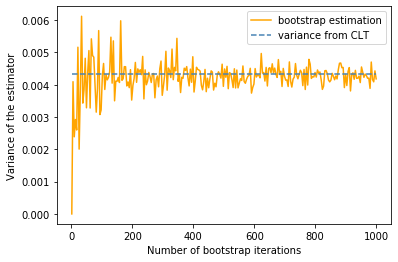

In [203]:
# Example: estimate the confidence interval for the mean of the head-turn delay on the ASD group 
# using bootstrap and the pivotal interval method. 
X = Xp ; n = len(X); bar_X = np.mean(X) 
# Recall our previous confidence interval estimation using the CLT. 
# Empirical variance (un-biased estimator using 1/n-1). 
var = lambda X: 1/(len(X)-1) * np.sum(np.array( [(X_i-np.mean(X))**2 for X_i in X] ))
se = np.sqrt(var(X)/n)  # Using CLT 

# Now using bootstrap
def bootstrap(X,B):
    bar_X_b = []
    for b in range(B):
        X_b = np.random.choice(X, n, replace=True)  # Get n samples from {X_1,...,X_n} with replacement. 
        bar_X_b.append(np.mean(X_b))  # Estimate the mean from the sample
    # Compute the mean of the estimated values
    v_boot = np.var(bar_X_b)
    return v_boot

print(color.BOLD + '           Figure 2.9: Bootstrap variance estimation.' + color.END)
Bs = np.linspace(1,1000,250); v_boots = [bootstrap(X,int(B)) for B in Bs];
plt.plot(Bs, v_boots, '-', color='orange'); 
plt.plot(Bs, [se**2 for B in Bs], '--', color='steelblue');
plt.legend(['bootstrap estimation', 'variance from CLT']); 
plt.xlabel('Number of bootstrap iterations'); plt.ylabel('Variance of the estimator');

In [205]:
# Compare 95% confidence intervals from bootstrap and from the CLT. 
alpha = 0.05
B = 200; bar_X_b = []
for b in range(B):
    X_b = np.random.choice(X, n, replace=True)  # Get n samples from {X_1,...,X_n} with replacement. 
    bar_X_b.append(np.mean(X_b))  # Estimate the mean from the sample

bar_X_u = np.quantile(bar_X_b, 1-alpha/2)
bar_X_l = np.quantile(bar_X_b, alpha/2)
hat_a = 2*bar_X - bar_X_u
hat_b = 2*bar_X - bar_X_l
print('Mean 95% conf interval from bootstrap :: ({:2.2f}, {:2.2f}) seconds'.format(hat_a, hat_b))
print('Mean 95% conf interval from CLT :: ({:2.2f}, {:2.2f}) seconds'.format(bar_X-2*se, bar_X+2*se))

Mean 95% conf interval from bootstrap :: (2.92, 3.20) seconds
Mean 95% conf interval from CLT :: (2.92, 3.18) seconds


## Section 3: Hypothesis testing
- 3.1: Definition and general concepts
- 3.2: Limitations and some comments
- 3.3: Examples

## Section 4: Others
- Effect size, t-test, ICC, kappa


Check this references. 
- http://www.math.ucsd.edu/~rxu/math284/slect2.pdf
- https://web.stanford.edu/~lutian/coursepdf/unitweek3.pdf
- https://web.stanford.edu/~lutian/coursepdf/survweek3.pdf
- http://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_Survival/BS704_Survival5.html


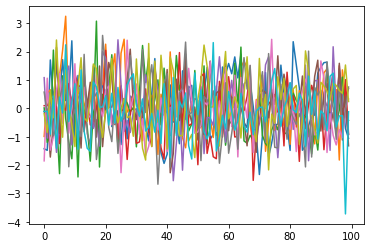

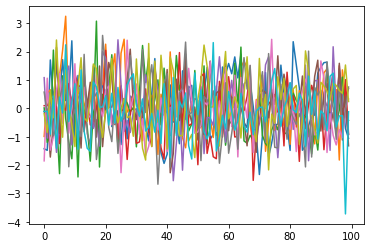

In [179]:
%matplotlib inline
import time
import pylab as pl
from IPython import display
for i in range(10):
    r = np.random.randn(100)
    plt.plot(r)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1.0)
